# Import necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow==2.15.0

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

Define paths for training and validation datasets

In [ ]:
base_dir = '/content/drive/MyDrive/Product_Recognition_Categorisation/Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


Define image size, batch size, and number of classes

In [ ]:
image_size = (64, 64)
batch_size = 32

Data Augmentation for training set & only recscaling the validation dataset

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',

)

validation_datagen = ImageDataGenerator(rescale=1./255)

Load Training and validation data

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3425 images belonging to 3 classes.
Found 404 images belonging to 3 classes.


In [ ]:
main_class_names = list(train_generator.class_indices.keys())
print("Class names:", main_class_names)

num_main_categories = len(main_class_names)

Class names: ['Fruits', 'Packages', 'Vegetables']


# Load the VGG16 model with pre-trained ImageNet weights, excluding the top layers

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

58889256/58889256 [==============================] - 0s 0us/step


Freeze the layers of the base model

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Build the main category model

In [ ]:
input_shape = (64, 64, 3)
main_category_model = Sequential([
    base_model, # VGG16 pre-trained model
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_main_categories, activation='softmax')
])

Compile and train the model. Including the model summary

In [ ]:
main_category_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model checkpoint callback
checkpoint = ModelCheckpoint('best_main_category_model.h5', monitor='val_loss', save_best_only=True)

history = main_category_model.fit(
train_generator,
steps_per_epoch=train_generator.samples // batch_size,
validation_data=validation_generator,
validation_steps=validation_generator.samples // batch_size,
epochs=30
callbacks=[early_stopping, checkpoint]
)


Epoch 1/30
 10/107 [=>............................] - ETA: 14:29 - loss: 1.0201 - accuracy: 0.5917

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


107/107 [==============================] - 1007s 9s/step - loss: 0.6685 - accuracy: 0.7009 - val_loss: 0.4372 - val_accuracy: 0.7708
Epoch 2/30
107/107 [==============================] - 99s 930ms/step - loss: 0.5433 - accuracy: 0.7459 - val_loss: 0.4182 - val_accuracy: 0.8307
Epoch 3/30
107/107 [==============================] - 98s 917ms/step - loss: 0.5203 - accuracy: 0.7586 - val_loss: 0.4027 - val_accuracy: 0.8594
Epoch 4/30
107/107 [==============================] - 98s 917ms/step - loss: 0.4963 - accuracy: 0.7713 - val_loss: 0.4062 - val_accuracy: 0.8464
Epoch 5/30
107/107 [==============================] - 100s 936ms/step - loss: 0.4841 - accuracy: 0.7772 - val_loss: 0.3719 - val_accuracy: 0.8542
Epoch 6/30
107/107 [==============================] - 99s 921ms/step - loss: 0.4798 - accuracy: 0.7804 - val_loss: 0.3714 - val_accuracy: 0.8464
Epoch 7/30
107/107 [==============================] - 99s 927ms/step - loss: 0.4546 - accuracy: 0.7896 - val_loss: 0.3543 - val_accuracy: 0.8

Save the model

In [ ]:
main_category_model.save('/content/drive/MyDrive/Product_Recognition_Categorisation/Models/main_category_vgg16.h5', save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##  Plot training & validation accuracy values

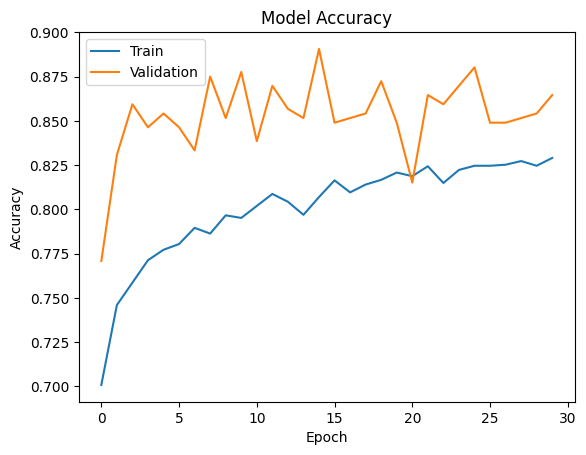

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##  Plot training & validation loss values

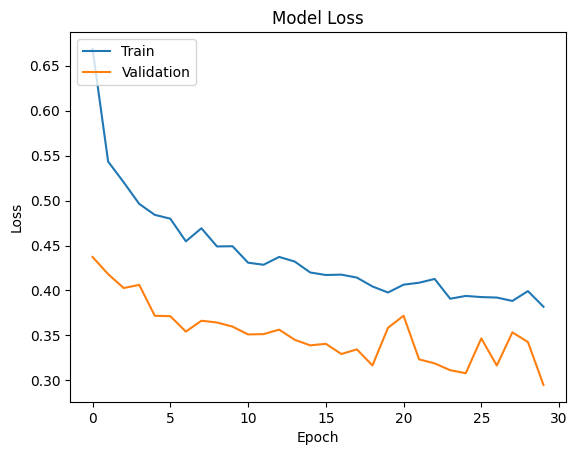

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()